# SPCBViTNet – Adagrad Ablation

📌 Part of the ablation study for the submission:  
**"SPCBViTNet: Enhancing Skin Cancer Diagnosis with Multi-Scale Vision Transformers and Adaptive Spatial-Channel Attention"**

🔒 Not yet peer-reviewed. For review only.  
📁 [GitHub Repo](https://github.com/diyagoyal31/SPCBViT)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
from torchvision import transforms
from PIL import Image
class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform  # Default transform applied in __getitem__
        self.image_paths = []
        self.labels = []

        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        for cls_name in self.class_names:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):  # Supports multiple formats
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transform (if provided), otherwise apply default ToTensor
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(label, dtype=torch.long)

In [4]:
import torchvision.transforms.functional as TF
import random

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SKFeaturePyramid(nn.Module):
    def __init__(self, in_channels):
        super(SKFeaturePyramid, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2)
        self.fc = nn.Linear(in_channels, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv3(x)
        f3 = self.conv5(x)
        f_sum = f1 + f2 + f3
        f_weights = self.softmax(self.fc(f_sum.mean(dim=(2, 3)))).unsqueeze(-1).unsqueeze(-1)
        return f1 * f_weights[:, 0].view(-1, 1, 1, 1) + \
               f2 * f_weights[:, 1].view(-1, 1, 1, 1) + \
               f3 * f_weights[:, 2].view(-1, 1, 1, 1)


class SelfInteractiveAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfInteractiveAttention, self).__init__()
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)

    def forward(self, x):
        ca = self.channel_attn(x) * x
        sa = torch.sigmoid(self.spatial_attn(x)) * x
        return ca + sa


class HigherOrderInteraction(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels):
        super(HigherOrderInteraction, self).__init__()
        self.conv1 = nn.Conv2d(in_channels1, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels2, out_channels, kernel_size=1)
        self.bilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.trilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        if x1.shape[2:] != x2.shape[2:]:
            x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        return self.bilinear_pool(x1 * x2) + self.trilinear_pool(x1 + x2)


class SPCBViTNet(nn.Module):
    def __init__(self, vit_model, num_classes, patch_grid=(14, 14)):
        super(SPCBViTNet, self).__init__()
        self.vit_model = vit_model
        self.hidden_size = vit_model.config.hidden_size
        self.patch_grid = patch_grid  # E.g. 14x14 for ViT-B/16

        # SPCB modules
        self.sk = SKFeaturePyramid(self.hidden_size)
        self.attn = SelfInteractiveAttention(self.hidden_size)
        self.higher_order = HigherOrderInteraction(self.hidden_size, self.hidden_size, self.hidden_size)

        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_out = self.vit_model(pixel_values=x).last_hidden_state  # [B, N+1, C]
        cls_token = vit_out[:, 0]  # CLS token
        patch_tokens = vit_out[:, 1:]  # [B, N, C]

        # Convert patch tokens to 2D feature maps
        B, N, C = patch_tokens.size()
        H, W = self.patch_grid
        patch_map = patch_tokens.permute(0, 2, 1).contiguous().view(B, C, H, W)

        # SPCB modules
        f1 = self.sk(patch_map)
        f2 = self.attn(f1)
        f3 = self.higher_order(f1, f2)

        out = self.global_avg(f3).view(B, -1)
        return self.classifier(out)


In [6]:
from transformers import ViTModel

vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

model = SPCBViTNet(vit_model=vit_model, num_classes=7, patch_grid=(14, 14))


2025-05-18 12:17:49.685913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747570669.874316      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747570669.927996      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
from torchvision import transforms
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim import Adagrad
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# ✅ Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# ✅ Only Tensor + Normalization for Testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load full dataset (with neutral transform for indexing)
base_dataset = SkinCancerDataset(root_dir="/kaggle/input/skinnnnn/dataset_split_2/", transform=transforms.ToTensor())

NUM_CLASSES = len(base_dataset.class_to_idx)
BATCH_SIZE = 32
EPOCHS = 50
K_FOLDS = 10
LEARNING_RATE = 0.0001

# Extract labels to stratify
targets = [base_dataset[i][1] for i in range(len(base_dataset))]

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(targets)), targets))

all_true_labels = []
all_pred_labels = []
all_probs = []

for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"\n🚀 Training Fold {fold + 1}/{K_FOLDS}")

    # Separate datasets to avoid transform leakage
    train_dataset = SkinCancerDataset(root_dir="/kaggle/input/skinnnnn/dataset_split_2/", transform=train_transform)
    test_dataset = SkinCancerDataset(root_dir="/kaggle/input/skinnnnn/dataset_split_2/", transform=test_transform)

    train_subset = Subset(train_dataset, train_idx)
    test_subset = Subset(test_dataset, test_idx)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = SPCBViTNet(vit_model=vit_model, num_classes=NUM_CLASSES).to(device)

    optimizer = Adagrad(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only trainable parameters
    lr=LEARNING_RATE,
    weight_decay=1e-4   # Optional: L2 regularization
    )



    criterion = CrossEntropyLoss()

    # Checkpoint path
    checkpoint_path = f"best_model_fold_{fold + 1}.pth"

    # Load checkpoint if available
    best_acc = 0.0
    start_epoch = 0
    if os.path.exists(checkpoint_path):
       checkpoint = torch.load(checkpoint_path)
       model.load_state_dict(checkpoint["model_state_dict"])
       start_epoch = checkpoint["epoch"] + 1
       best_acc = checkpoint["best_acc"]
    print(f"🔄 Resuming from epoch {start_epoch}, best accuracy: {best_acc:.2f}%")

    patience = 5  # Stop if no improvement for 5 epochs
    patience_counter = 0

    for epoch in range(start_epoch, EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        # Testing Loop
        model.eval()
        test_correct, test_total = 0, 0
        fold_preds, fold_labels, fold_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                fold_preds.extend(predicted.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())
                fold_probs.extend(probs.cpu().numpy())

                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_acc = 100 * test_correct / test_total
        print(f"✅ Fold {fold+1}: Test Accuracy = {test_acc:.2f}%")

        # Early stopping check
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_acc": best_acc,
            }, checkpoint_path)
            print(f"🎯 New best model saved with accuracy: {best_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"🛑 Early stopping triggered at epoch {epoch+1}")
                break


    all_true_labels.extend(fold_labels)
    all_pred_labels.extend(fold_preds)
    all_probs.extend(fold_probs)



🚀 Training Fold 1/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.52it/s, acc=53.6, loss=0.965]


✅ Fold 1: Test Accuracy = 65.22%
🎯 New best model saved with accuracy: 65.22%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=65.3, loss=0.855]


✅ Fold 1: Test Accuracy = 69.57%
🎯 New best model saved with accuracy: 69.57%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=69.3, loss=0.81] 


✅ Fold 1: Test Accuracy = 68.26%
⏳ No improvement. Patience counter: 1/5


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=71.5, loss=0.681]


✅ Fold 1: Test Accuracy = 68.26%
⏳ No improvement. Patience counter: 2/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=73.7, loss=0.926]


✅ Fold 1: Test Accuracy = 73.48%
🎯 New best model saved with accuracy: 73.48%


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=75.4, loss=0.582]


✅ Fold 1: Test Accuracy = 71.74%
⏳ No improvement. Patience counter: 1/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=76.5, loss=0.504]


✅ Fold 1: Test Accuracy = 71.74%
⏳ No improvement. Patience counter: 2/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=76.6, loss=0.623]


✅ Fold 1: Test Accuracy = 72.17%
⏳ No improvement. Patience counter: 3/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=77.4, loss=0.763]


✅ Fold 1: Test Accuracy = 73.04%
⏳ No improvement. Patience counter: 4/5


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=79.1, loss=0.84] 


✅ Fold 1: Test Accuracy = 74.35%
🎯 New best model saved with accuracy: 74.35%


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=80.6, loss=0.655]


✅ Fold 1: Test Accuracy = 72.61%
⏳ No improvement. Patience counter: 1/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=80.9, loss=0.609]


✅ Fold 1: Test Accuracy = 74.35%
⏳ No improvement. Patience counter: 2/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=81, loss=0.265]  


✅ Fold 1: Test Accuracy = 70.87%
⏳ No improvement. Patience counter: 3/5


Epoch [14/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=83.4, loss=0.671]


✅ Fold 1: Test Accuracy = 73.48%
⏳ No improvement. Patience counter: 4/5


Epoch [15/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=83.8, loss=0.565]


✅ Fold 1: Test Accuracy = 73.91%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 15

🚀 Training Fold 2/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=69.4, loss=1.09] 


✅ Fold 2: Test Accuracy = 73.91%
🎯 New best model saved with accuracy: 73.91%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=79.5, loss=0.569]


✅ Fold 2: Test Accuracy = 73.48%
⏳ No improvement. Patience counter: 1/5


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=80.9, loss=0.614]


✅ Fold 2: Test Accuracy = 77.39%
🎯 New best model saved with accuracy: 77.39%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=83.4, loss=0.5]  


✅ Fold 2: Test Accuracy = 77.39%
⏳ No improvement. Patience counter: 1/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=84.5, loss=0.257]


✅ Fold 2: Test Accuracy = 77.83%
🎯 New best model saved with accuracy: 77.83%


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=85.9, loss=0.32] 


✅ Fold 2: Test Accuracy = 77.39%
⏳ No improvement. Patience counter: 1/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=86.4, loss=0.303]


✅ Fold 2: Test Accuracy = 78.70%
🎯 New best model saved with accuracy: 78.70%


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=87.3, loss=0.35]  


✅ Fold 2: Test Accuracy = 79.57%
🎯 New best model saved with accuracy: 79.57%


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=88.7, loss=0.0394]


✅ Fold 2: Test Accuracy = 76.52%
⏳ No improvement. Patience counter: 1/5


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=88.8, loss=0.577] 


✅ Fold 2: Test Accuracy = 79.57%
⏳ No improvement. Patience counter: 2/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=90.5, loss=0.225] 


✅ Fold 2: Test Accuracy = 79.57%
⏳ No improvement. Patience counter: 3/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=90.5, loss=0.119] 


✅ Fold 2: Test Accuracy = 77.83%
⏳ No improvement. Patience counter: 4/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=90.1, loss=0.162] 


✅ Fold 2: Test Accuracy = 78.26%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 13

🚀 Training Fold 3/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=76.5, loss=0.566]


✅ Fold 3: Test Accuracy = 80.43%
🎯 New best model saved with accuracy: 80.43%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=85.8, loss=0.743] 


✅ Fold 3: Test Accuracy = 80.87%
🎯 New best model saved with accuracy: 80.87%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=88.5, loss=0.313]


✅ Fold 3: Test Accuracy = 85.22%
🎯 New best model saved with accuracy: 85.22%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=90.2, loss=0.0768]


✅ Fold 3: Test Accuracy = 86.09%
🎯 New best model saved with accuracy: 86.09%


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=91.6, loss=0.68]  


✅ Fold 3: Test Accuracy = 85.65%
⏳ No improvement. Patience counter: 1/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=92.4, loss=0.0336]


✅ Fold 3: Test Accuracy = 85.65%
⏳ No improvement. Patience counter: 2/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=93.5, loss=0.111] 


✅ Fold 3: Test Accuracy = 83.91%
⏳ No improvement. Patience counter: 3/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=93.7, loss=0.299] 


✅ Fold 3: Test Accuracy = 83.48%
⏳ No improvement. Patience counter: 4/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.1, loss=0.0809]


✅ Fold 3: Test Accuracy = 83.48%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 9

🚀 Training Fold 4/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=80.7, loss=0.335]


✅ Fold 4: Test Accuracy = 87.39%
🎯 New best model saved with accuracy: 87.39%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=91, loss=0.488]   


✅ Fold 4: Test Accuracy = 89.13%
🎯 New best model saved with accuracy: 89.13%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=93.3, loss=0.167] 


✅ Fold 4: Test Accuracy = 88.26%
⏳ No improvement. Patience counter: 1/5


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.3, loss=0.239] 


✅ Fold 4: Test Accuracy = 88.70%
⏳ No improvement. Patience counter: 2/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.4, loss=0.207] 


✅ Fold 4: Test Accuracy = 89.13%
⏳ No improvement. Patience counter: 3/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.2, loss=0.185] 


✅ Fold 4: Test Accuracy = 90.87%
🎯 New best model saved with accuracy: 90.87%


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.3, loss=0.124] 


✅ Fold 4: Test Accuracy = 90.87%
⏳ No improvement. Patience counter: 1/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.7, loss=0.0457]


✅ Fold 4: Test Accuracy = 91.74%
🎯 New best model saved with accuracy: 91.74%


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.1, loss=0.0593]


✅ Fold 4: Test Accuracy = 91.30%
⏳ No improvement. Patience counter: 1/5


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=97.3, loss=0.0557] 


✅ Fold 4: Test Accuracy = 91.74%
⏳ No improvement. Patience counter: 2/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=97.4, loss=0.107]  


✅ Fold 4: Test Accuracy = 90.87%
⏳ No improvement. Patience counter: 3/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.8, loss=0.0141]


✅ Fold 4: Test Accuracy = 90.43%
⏳ No improvement. Patience counter: 4/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=97.9, loss=0.189]  


✅ Fold 4: Test Accuracy = 90.43%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 13

🚀 Training Fold 5/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=85.1, loss=0.0388]


✅ Fold 5: Test Accuracy = 88.70%
🎯 New best model saved with accuracy: 88.70%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=94.3, loss=0.157] 


✅ Fold 5: Test Accuracy = 91.30%
🎯 New best model saved with accuracy: 91.30%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96, loss=0.239]   


✅ Fold 5: Test Accuracy = 92.17%
🎯 New best model saved with accuracy: 92.17%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.3, loss=0.0291]


✅ Fold 5: Test Accuracy = 92.61%
🎯 New best model saved with accuracy: 92.61%


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.6, loss=0.161] 


✅ Fold 5: Test Accuracy = 91.30%
⏳ No improvement. Patience counter: 1/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.2, loss=0.0178] 


✅ Fold 5: Test Accuracy = 93.91%
🎯 New best model saved with accuracy: 93.91%


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=98.4, loss=0.00624]


✅ Fold 5: Test Accuracy = 93.91%
⏳ No improvement. Patience counter: 1/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=97.9, loss=0.0554] 


✅ Fold 5: Test Accuracy = 93.48%
⏳ No improvement. Patience counter: 2/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.00645]


✅ Fold 5: Test Accuracy = 93.04%
⏳ No improvement. Patience counter: 3/5


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.3, loss=0.137]  


✅ Fold 5: Test Accuracy = 93.48%
⏳ No improvement. Patience counter: 4/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.3, loss=0.207]  


✅ Fold 5: Test Accuracy = 94.35%
🎯 New best model saved with accuracy: 94.35%


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=98.4, loss=0.1]    


✅ Fold 5: Test Accuracy = 93.91%
⏳ No improvement. Patience counter: 1/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.00317]


✅ Fold 5: Test Accuracy = 93.91%
⏳ No improvement. Patience counter: 2/5


Epoch [14/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=98.8, loss=0.0163] 


✅ Fold 5: Test Accuracy = 93.04%
⏳ No improvement. Patience counter: 3/5


Epoch [15/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.0187] 


✅ Fold 5: Test Accuracy = 93.04%
⏳ No improvement. Patience counter: 4/5


Epoch [16/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=98.5, loss=0.0177] 


✅ Fold 5: Test Accuracy = 92.61%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 16

🚀 Training Fold 6/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=86.6, loss=0.0564]


✅ Fold 6: Test Accuracy = 93.48%
🎯 New best model saved with accuracy: 93.48%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=95.5, loss=0.0926]


✅ Fold 6: Test Accuracy = 92.61%
⏳ No improvement. Patience counter: 1/5


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97, loss=0.0577]   


✅ Fold 6: Test Accuracy = 94.78%
🎯 New best model saved with accuracy: 94.78%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.1, loss=0.0249] 


✅ Fold 6: Test Accuracy = 96.52%
🎯 New best model saved with accuracy: 96.52%


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.9, loss=0.0264] 


✅ Fold 6: Test Accuracy = 95.65%
⏳ No improvement. Patience counter: 1/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.5, loss=0.0067] 


✅ Fold 6: Test Accuracy = 96.52%
⏳ No improvement. Patience counter: 2/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.2, loss=0.00295]


✅ Fold 6: Test Accuracy = 96.52%
⏳ No improvement. Patience counter: 3/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.0201] 


✅ Fold 6: Test Accuracy = 96.52%
⏳ No improvement. Patience counter: 4/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.5, loss=0.0109] 


✅ Fold 6: Test Accuracy = 96.52%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 9

🚀 Training Fold 7/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=88.9, loss=0.12]  


✅ Fold 7: Test Accuracy = 94.35%
🎯 New best model saved with accuracy: 94.35%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.2, loss=0.0776]


✅ Fold 7: Test Accuracy = 93.48%
⏳ No improvement. Patience counter: 1/5


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.1, loss=0.0237] 


✅ Fold 7: Test Accuracy = 95.22%
🎯 New best model saved with accuracy: 95.22%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.5, loss=0.0889] 


✅ Fold 7: Test Accuracy = 94.78%
⏳ No improvement. Patience counter: 1/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.2, loss=0.021]  


✅ Fold 7: Test Accuracy = 96.96%
🎯 New best model saved with accuracy: 96.96%


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.356]  


✅ Fold 7: Test Accuracy = 95.65%
⏳ No improvement. Patience counter: 1/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.00423]


✅ Fold 7: Test Accuracy = 97.39%
🎯 New best model saved with accuracy: 97.39%


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.00796]  


✅ Fold 7: Test Accuracy = 95.22%
⏳ No improvement. Patience counter: 1/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.5, loss=0.0778] 


✅ Fold 7: Test Accuracy = 96.96%
⏳ No improvement. Patience counter: 2/5


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.5, loss=0.00608]


✅ Fold 7: Test Accuracy = 95.65%
⏳ No improvement. Patience counter: 3/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.0209] 


✅ Fold 7: Test Accuracy = 97.39%
⏳ No improvement. Patience counter: 4/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.1, loss=0.00215]


✅ Fold 7: Test Accuracy = 96.09%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 12

🚀 Training Fold 8/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=90.7, loss=0.0122]


✅ Fold 8: Test Accuracy = 93.48%
🎯 New best model saved with accuracy: 93.48%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.6, loss=0.0114] 


✅ Fold 8: Test Accuracy = 97.39%
🎯 New best model saved with accuracy: 97.39%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.3, loss=0.0326] 


✅ Fold 8: Test Accuracy = 95.22%
⏳ No improvement. Patience counter: 1/5


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.107]  


✅ Fold 8: Test Accuracy = 94.78%
⏳ No improvement. Patience counter: 2/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.0832] 


✅ Fold 8: Test Accuracy = 95.65%
⏳ No improvement. Patience counter: 3/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.0249]   


✅ Fold 8: Test Accuracy = 96.52%
⏳ No improvement. Patience counter: 4/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.7, loss=0.00429]


✅ Fold 8: Test Accuracy = 95.65%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 7

🚀 Training Fold 9/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=90.4, loss=0.0302]


✅ Fold 9: Test Accuracy = 97.38%
🎯 New best model saved with accuracy: 97.38%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.6, loss=0.0539] 


✅ Fold 9: Test Accuracy = 97.38%
⏳ No improvement. Patience counter: 1/5


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.8, loss=0.26]   


✅ Fold 9: Test Accuracy = 98.69%
🎯 New best model saved with accuracy: 98.69%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.2, loss=0.0138] 


✅ Fold 9: Test Accuracy = 97.82%
⏳ No improvement. Patience counter: 1/5


Epoch [5/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.7, loss=0.00378]


✅ Fold 9: Test Accuracy = 98.69%
⏳ No improvement. Patience counter: 2/5


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.7, loss=0.00533]


✅ Fold 9: Test Accuracy = 98.69%
⏳ No improvement. Patience counter: 3/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.00343]  


✅ Fold 9: Test Accuracy = 98.25%
⏳ No improvement. Patience counter: 4/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.9, loss=0.0033] 


✅ Fold 9: Test Accuracy = 99.13%
🎯 New best model saved with accuracy: 99.13%


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.0143]   


✅ Fold 9: Test Accuracy = 99.56%
🎯 New best model saved with accuracy: 99.56%


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.9, loss=0.000839]


✅ Fold 9: Test Accuracy = 99.13%
⏳ No improvement. Patience counter: 1/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.00191]  


✅ Fold 9: Test Accuracy = 99.13%
⏳ No improvement. Patience counter: 2/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.9, loss=0.0392]  


✅ Fold 9: Test Accuracy = 99.13%
⏳ No improvement. Patience counter: 3/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.00301]   


✅ Fold 9: Test Accuracy = 98.69%
⏳ No improvement. Patience counter: 4/5


Epoch [14/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.9, loss=0.00518]


✅ Fold 9: Test Accuracy = 98.69%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 14

🚀 Training Fold 10/10
🔄 Resuming from epoch 0, best accuracy: 0.00%


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=91, loss=0.048]   


✅ Fold 10: Test Accuracy = 96.07%
🎯 New best model saved with accuracy: 96.07%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.2, loss=0.0117] 


✅ Fold 10: Test Accuracy = 98.69%
🎯 New best model saved with accuracy: 98.69%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.132]  


✅ Fold 10: Test Accuracy = 98.25%
⏳ No improvement. Patience counter: 1/5


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.8, loss=0.15]   


✅ Fold 10: Test Accuracy = 97.82%
⏳ No improvement. Patience counter: 2/5


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.8, loss=0.00181]


✅ Fold 10: Test Accuracy = 99.13%
🎯 New best model saved with accuracy: 99.13%


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.187]    


✅ Fold 10: Test Accuracy = 97.82%
⏳ No improvement. Patience counter: 1/5


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.0047]   


✅ Fold 10: Test Accuracy = 99.13%
⏳ No improvement. Patience counter: 2/5


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.9, loss=0.000859]


✅ Fold 10: Test Accuracy = 98.69%
⏳ No improvement. Patience counter: 3/5


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99, loss=0.0773]    


✅ Fold 10: Test Accuracy = 99.56%
🎯 New best model saved with accuracy: 99.56%


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.3, loss=0.0223]  


✅ Fold 10: Test Accuracy = 99.56%
⏳ No improvement. Patience counter: 1/5


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.2, loss=0.00158] 


✅ Fold 10: Test Accuracy = 99.56%
⏳ No improvement. Patience counter: 2/5


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.1, loss=0.000859]


✅ Fold 10: Test Accuracy = 99.56%
⏳ No improvement. Patience counter: 3/5


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.2, loss=0.00202] 


✅ Fold 10: Test Accuracy = 99.13%
⏳ No improvement. Patience counter: 4/5


Epoch [14/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=99.2, loss=0.00203] 


✅ Fold 10: Test Accuracy = 99.56%
⏳ No improvement. Patience counter: 5/5
🛑 Early stopping triggered at epoch 14



📊 Final Evaluation Across All Folds:


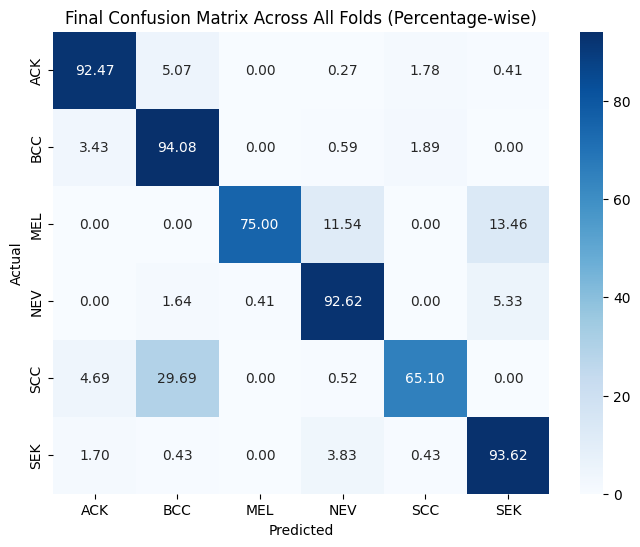

              precision    recall  f1-score   support

         ACK     0.9414    0.9247    0.9330       730
         BCC     0.8893    0.9408    0.9143       845
         MEL     0.9750    0.7500    0.8478        52
         NEV     0.9076    0.9262    0.9168       244
         SCC     0.8065    0.6510    0.7205       192
         SEK     0.9053    0.9362    0.9205       235

    accuracy                         0.9051      2298
   macro avg     0.9042    0.8548    0.8755      2298
weighted avg     0.9044    0.9051    0.9034      2298



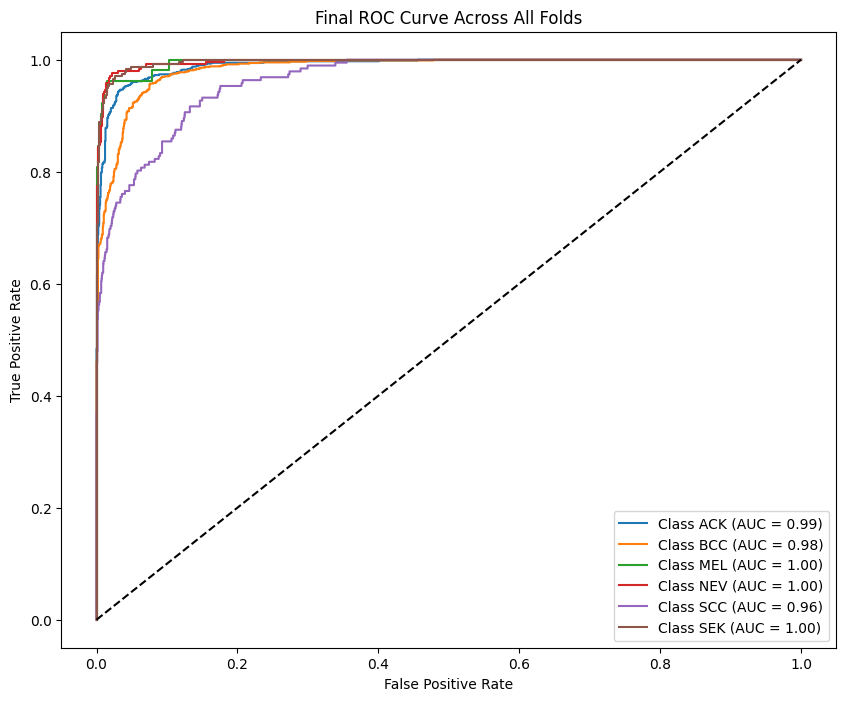

In [8]:

from sklearn.metrics import confusion_matrix
import numpy as np  # Ensure numpy is also imported
print("\n📊 Final Evaluation Across All Folds:")

cm = confusion_matrix(all_true_labels, all_pred_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=base_dataset.class_to_idx.keys(), 
            yticklabels=base_dataset.class_to_idx.keys())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix Across All Folds (Percentage-wise)")
plt.show()

class_report = classification_report(all_true_labels, all_pred_labels, target_names=base_dataset.class_to_idx.keys(), digits=4)
print(class_report)

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_true_labels) == i, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(base_dataset.class_to_idx.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve Across All Folds")
plt.legend(loc="lower right")
plt.show()
